# For halo 0 of each sim, graph and save the model

In [2]:
import matplotlib.pyplot as plt, numpy as np, joblib, os, time, bisect
from sklearn.model_selection import train_test_split 
from stellarutil import Simulation, Star 
from sklearn.neighbors import KNeighborsRegressor 
from IPython.display import clear_output

def graph(x,y,c, title, Y, Y_pred):
    # Create a figure
    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)
    # 2D Scatter Plot
    plt.subplot(1, 3, 1) # rows, cols, index
    plt.title("2D Star Positions")
    plt.scatter(x, y, label='Data Points', c=c, vmin=0, vmax=100)
    cb = plt.colorbar()
    cb.set_label('Percent Difference [%]')
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    # Predicted vs Actual
    plt.subplot(1, 3, 2)
    plt.title("Predicted vs Actual Dark Matter Masses")
    plt.scatter(Y, Y_pred, label='Data Points', c=c, vmin=0, vmax=100)
    cb = plt.colorbar()
    cb.set_label('Percent Difference [%]')
    # Get the max and min value and plot y=x line
    minVal = min(min(Y), min(Y_pred))
    maxVal = max(max(Y), max(Y_pred))
    plt.plot([minVal, maxVal], [minVal, maxVal], color='green', label='y = x')
    # Add labels and legend
    plt.xlabel('Actual Mass [M☉]')
    plt.ylabel('Predicted Mass [M☉]')
    plt.legend()
    plt.loglog()
    # Bin
    plt.subplot(1, 3, 3).hist(c, bins=20)
    plt.title("Histogram of Percent Differences")
    plt.xlabel('Percent Difference [%]')
    plt.ylabel('Frequency')
    # Show the plots
    plt.tight_layout()
    txt=f"Halo 0 has {len(Y)} stars. The average percent difference is {np.mean(c):.2f}%."
    plt.figtext(0.5, -0.02, txt, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()
    fig.savefig(f"../images/{title}_plot.png", bbox_inches="tight")

def split_data(X, Y, test_size=0.2, random_state=42):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    X_TRAIN = np.array(X_train) 
    Y_TRAIN = np.array(Y_train)
    X_TEST = np.array(X_test)
    Y_TEST = np.array(Y_test)
    return X_TRAIN, X_TEST, Y_TRAIN, Y_TEST

def processSim(sim_name: str):
    X = []
    Y = []
    start = time.time()
    sim = Simulation(simulation_name=sim_name, species=['star', 'dark'])
    clear_output()
    print(f'Loaded simulation in {round(time.time()-start,2)} seconds.')
    # Get the x,y,z positions of each dm particle in the simulation, normalize it with halo center
    dark_x = sim.particles['dark']['position'][:,0]
    dark_y = sim.particles['dark']['position'][:,1]
    dark_z = sim.particles['dark']['position'][:,2]
    # Get the mass of each dm particle in the simulation
    DM_MASS = 1303.0022
    # Get the halo and restrict
    halo = sim.get_halo(0)
    halo.restrict_percentage(15)
    # Get the x,y,z positions of each dm particle in the simulation, normalize it with halo center
    halo_dark_x = dark_x - halo.xc
    halo_dark_y = dark_y - halo.yc
    halo_dark_z = dark_z - halo.zc
    # Get the distance of each dm particle from the center of the indicated dark matter halo
    halo_dark_distances = np.sqrt(np.square(halo_dark_x) + np.square(halo_dark_y) + np.square(halo_dark_z))
    halo_dark_distances = np.sort(halo_dark_distances)
    # Get X and Y
    for star in halo.stars:
        X.append([star.x, star.y, star.vz, star.a, star.get_3DR(), star.get_3DR()])
        num_dm_particles = bisect.bisect_left(halo_dark_distances, star.get_3DR())
        Y.append(num_dm_particles * DM_MASS)
    print(f'Got X and Y in {round(time.time() - start,2)} seconds.')
    # Save X and Y in pickle files
    joblib.dump(X,f'../data/pickle/{sim_name}_X_halo_0.pkl')
    joblib.dump(Y,f'../data/pickle/{sim_name}_Y_halo_0.pkl')
    # Split the data
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = split_data(X, Y)
    # Create the KNN Regressor, train, and then predict
    knn_regressor = KNeighborsRegressor(n_neighbors=5)
    knn_regressor.fit(X_TRAIN, Y_TRAIN)
    Y_PRED = np.array(knn_regressor.predict(X_TEST))
    # Save the model
    joblib.dump(knn_regressor, f"model_{sim_name}.pkl")
    # Graph the results
    x = [star[0] for star in X_TEST]
    y = [star[1] for star in X_TEST]
    c = (np.abs(Y_TEST - Y_PRED) / ((Y_TEST + Y_PRED) / 2)) * 100
    graph(x, y, c, sim_name,Y_TEST, Y_PRED)


# names = ['m10q_res250md', 'm10r_res250md', 'm10v_res250md', 'm10v_res030md']

# for name in names:
#     processSim(name)



# Train Model Sigma on the same training stars

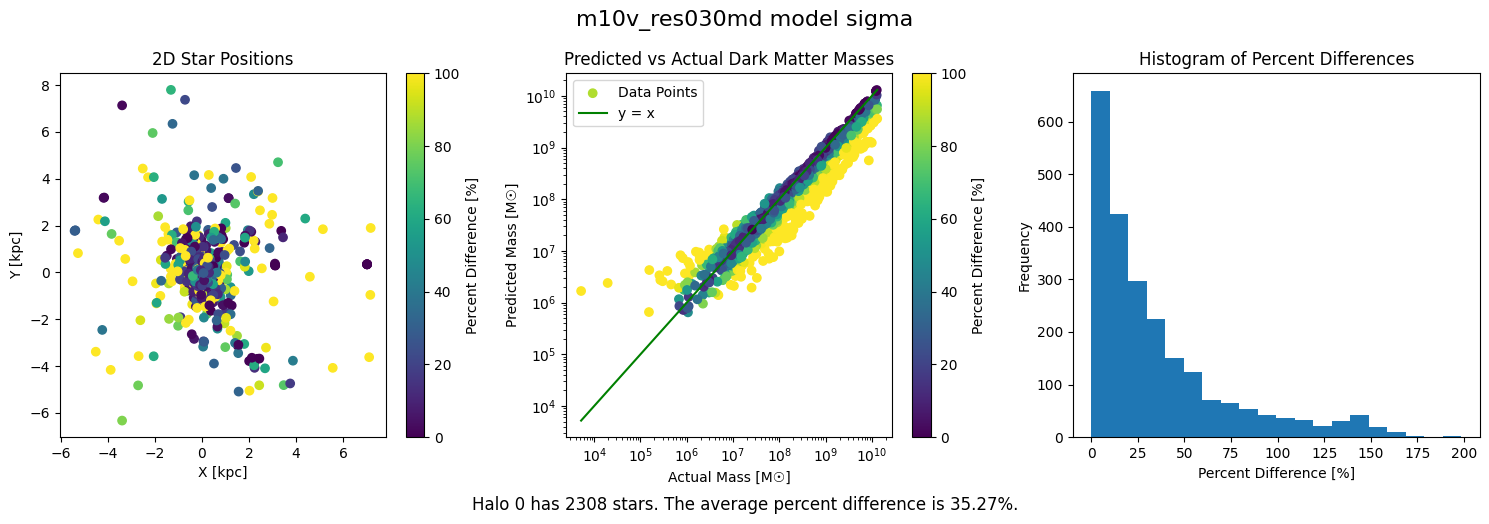

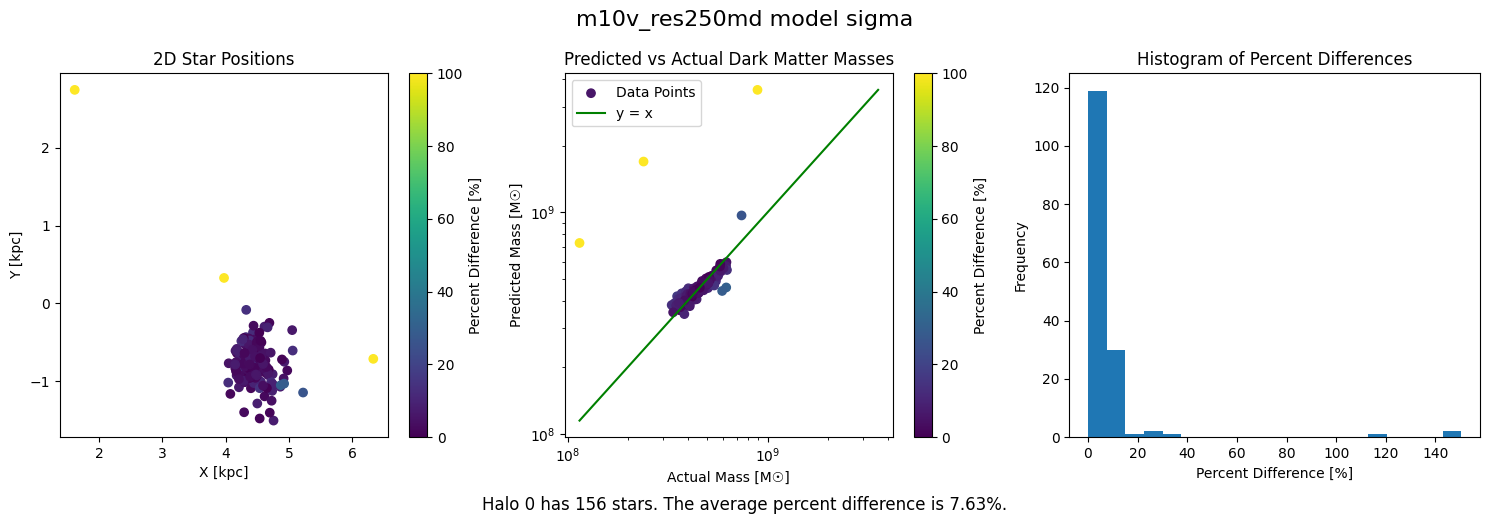

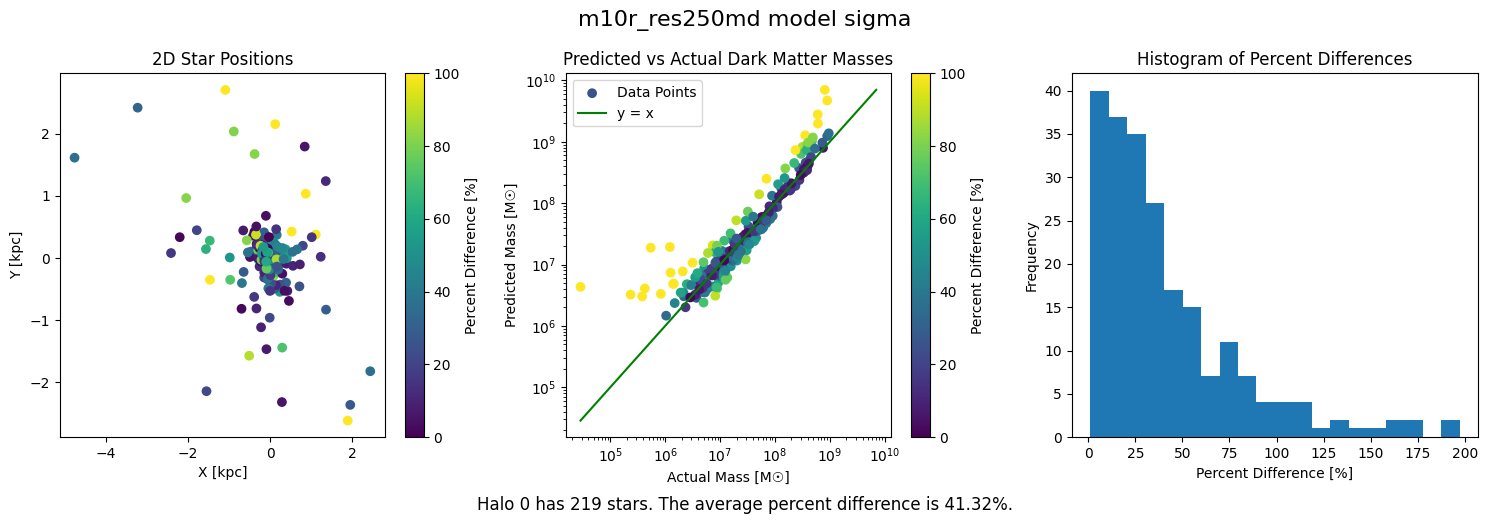

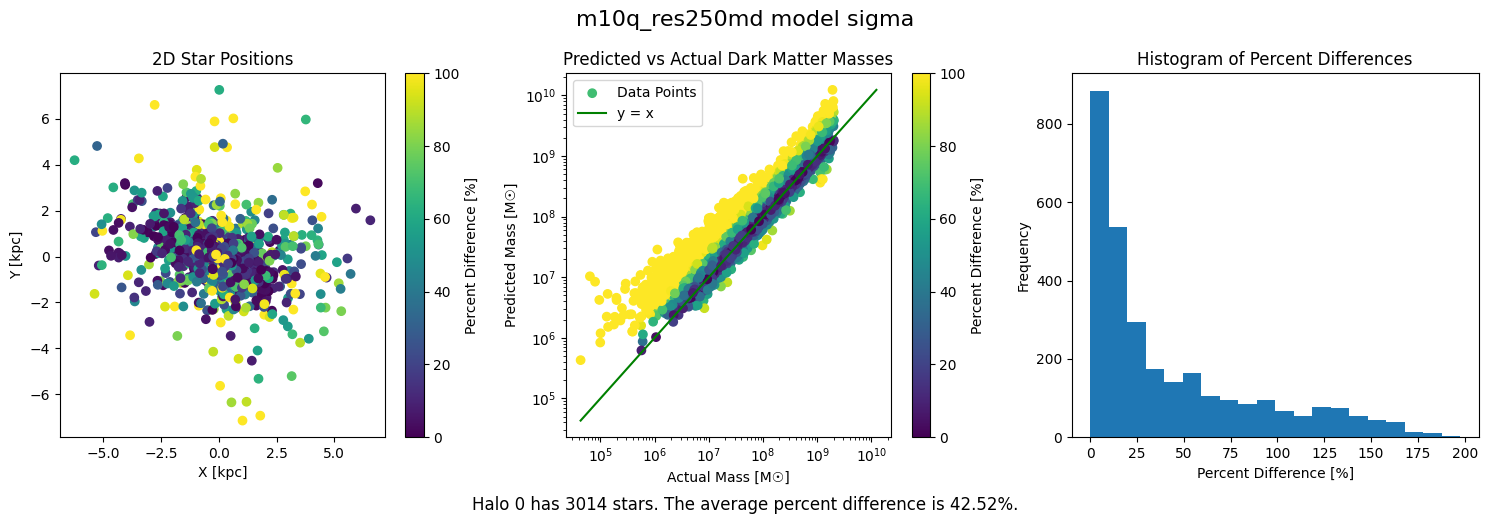

In [5]:
from sklearn.neighbors import KNeighborsRegressor 
import joblib, numpy as np


X_BV = joblib.load('../data/pickle/m10v_res030md_X_halo_0.pkl')
Y_BV = joblib.load('../data/pickle/m10v_res030md_Y_halo_0.pkl')
X_LV = joblib.load('../data/pickle/m10v_res250md_X_halo_0.pkl')
Y_LV = joblib.load('../data/pickle/m10v_res250md_Y_halo_0.pkl')
X_LR = joblib.load('../data/pickle/m10r_res250md_X_halo_0.pkl')
Y_LR = joblib.load('../data/pickle/m10r_res250md_Y_halo_0.pkl')
X_LQ = joblib.load('../data/pickle/m10q_res250md_X_halo_0.pkl')
Y_LQ = joblib.load('../data/pickle/m10q_res250md_Y_halo_0.pkl')                   

# Train on the same stars used to train the other models
X_TRAIN_BV, X_TEST_BV, Y_TRAIN_BV, Y_TEST_BV = split_data(X_BV, Y_BV)
X_TRAIN_LV, X_TEST_LV, Y_TRAIN_LV, Y_TEST_LV = split_data(X_LV, Y_LV)
X_TRAIN_LR, X_TEST_LR, Y_TRAIN_LR, Y_TEST_LR = split_data(X_LR, Y_LR)
X_TRAIN_LQ, X_TEST_LQ, Y_TRAIN_LQ, Y_TEST_LQ = split_data(X_LQ, Y_LQ)

X_TRAIN = np.concatenate((X_TRAIN_BV, X_TRAIN_LV, X_TRAIN_LR, X_TRAIN_LQ))
Y_TRAIN = np.concatenate((Y_TRAIN_BV, Y_TRAIN_LV, Y_TRAIN_LR, Y_TRAIN_LQ))

# Create the KNN Regressor, train, and then predict
model_sigma = KNeighborsRegressor(n_neighbors=5)
model_sigma.fit(X_TRAIN, Y_TRAIN)
# Save the big boy model
joblib.dump(model_sigma, "../data/pickle/model_sigma.pkl")

# Test the model on different sims

# BV
Y_PRED_BV = np.array(model_sigma.predict(X_TEST_BV))
# Graph the results
x = [star[0] for star in X_TEST_BV]
y = [star[1] for star in X_TEST_BV]
c = (np.abs(Y_TEST_BV - Y_PRED_BV) / ((Y_TEST_BV + Y_PRED_BV) / 2)) * 100
graph(x, y, c, "m10v_res030md model sigma",Y_TEST_BV, Y_PRED_BV)

# LV
Y_PRED_LV = np.array(model_sigma.predict(X_TEST_LV))
# Graph the results
x = [star[0] for star in X_TEST_LV]
y = [star[1] for star in X_TEST_LV]
c = (np.abs(Y_TEST_LV - Y_PRED_LV) / ((Y_TEST_LV + Y_PRED_LV) / 2)) * 100
graph(x, y, c, "m10v_res250md model sigma",Y_TEST_LV, Y_PRED_LV)

# LR
Y_PRED_LR = np.array(model_sigma.predict(X_TEST_LR))
# Graph the results
x = [star[0] for star in X_TEST_LR]
y = [star[1] for star in X_TEST_LR]
c = (np.abs(Y_TEST_LR - Y_PRED_LR) / ((Y_TEST_LR + Y_PRED_LR) / 2)) * 100
graph(x, y, c, "m10r_res250md model sigma",Y_TEST_LR, Y_PRED_LR)

# LQ
Y_PRED_LQ = np.array(model_sigma.predict(X_TEST_LQ))
# Graph the results
x = [star[0] for star in X_TEST_LQ]
y = [star[1] for star in X_TEST_LQ]
c = (np.abs(Y_TEST_LQ - Y_PRED_LQ) / ((Y_TEST_LQ + Y_PRED_LQ) / 2)) * 100
graph(x, y, c, "m10q_res250md model sigma",Y_TEST_LQ, Y_PRED_LQ)






# Make a prediction for LR and LQ

In [57]:
import numpy as np, pandas as pd

def predict_star_at_stellar_mass_ratio(model, halo, ratio=0.5):
    # Sort stars by 3D radius, stars closer to the center first
    sorted_stars = sorted(halo.stars, key=lambda star: star.get_3DR())
    # Get the total mass of all stars
    TOTAL_STAR_MASS = np.sum([star.m for star in sorted_stars])
    # Go through stars until half of the mass is enclosed
    enclosed_mass, star_index = 0, 0
    while True:
        enclosed_mass += sorted_stars[star_index].m
        star_index += 1
        if enclosed_mass >= TOTAL_STAR_MASS * ratio: break

    # Get the star at the index
    # star = sorted_stars[star_index]
    X = []
    for i in range(star_index-5, star_index+6):
        star = sorted_stars[i]
        X.append([star.x, star.y, star.vz, star.a, star.get_2DR(), star.get_2DR()])
    # Predict the star's enclosed dm mass
    prediction = model.predict(X)
    return np.mean(prediction)

def get_column(column, sim_name):
    # Load the CSV file
    df = pd.read_csv("jeans.csv")
    # Get the column of the CSV file
    vals = df.iloc[:, column].values
    # Convert the numbers from scientific notation to float
    vals = [float(num) for num in vals]
    if sim_name == "m10r_res250md":
        vals = vals[:len(vals)//2]
    else:
        vals = vals[len(vals)//2:]
    return vals

def test_sim(model, simName):
    # Load the simulation
    sim = Simulation(simulation_name=simName, species=['star'])
    clear_output()
    halo = sim.get_halo()
    halo.restrict_percentage(15)
    # Get the gas, star, and total masses from the CSV file
    gas_masses = get_column(5, simName)
    star_masses = get_column(7, simName)
    actual_total_masses = get_column(4, simName)
    # Make a predictiuon for each ratio
    ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    print('-' * 40, simName, '-' * 40)
    for index, ratio in enumerate(ratios):
        predicted_dm_mass = predict_star_at_stellar_mass_ratio(model,halo,ratio)
        print(f"Star at {ratio * 100}% of the total stellar mass has a predicted enclosed dark matter mass of {predicted_dm_mass:.2e} M☉.")
        predicted_total_mass = predicted_dm_mass + star_masses[index] + gas_masses[index]
        print(f"The total predicted mass is {predicted_total_mass:.2e} M☉.")
        actual_total_mass = actual_total_masses[index]
        print(f"The total actual mass is {actual_total_mass:.2e} M☉.")
        percent_diff = abs(actual_total_mass - predicted_total_mass) / ((actual_total_mass + predicted_total_mass) / 2) * 100
        print(f"The percent difference is {percent_diff:.2f}%.")
        print()

### m10r_res250md on model sigma

In [58]:
model_sigma = joblib.load("../data/pickle/model_sigma.pkl")
simName = "m10r_res250md"
test_sim(model_sigma, simName)

---------------------------------------- m10r_res250md ----------------------------------------
Star at 10.0% of the total stellar mass has a predicted enclosed dark matter mass of 5.57e+06 M☉.
The total predicted mass is 5.74e+06 M☉.
The total actual mass is 2.68e+06 M☉.
The percent difference is 72.71%.

Star at 20.0% of the total stellar mass has a predicted enclosed dark matter mass of 5.82e+06 M☉.
The total predicted mass is 6.17e+06 M☉.
The total actual mass is 6.74e+06 M☉.
The percent difference is 8.78%.

Star at 30.0% of the total stellar mass has a predicted enclosed dark matter mass of 1.16e+07 M☉.
The total predicted mass is 1.21e+07 M☉.
The total actual mass is 1.13e+07 M☉.
The percent difference is 7.25%.

Star at 40.0% of the total stellar mass has a predicted enclosed dark matter mass of 1.25e+07 M☉.
The total predicted mass is 1.32e+07 M☉.
The total actual mass is 1.78e+07 M☉.
The percent difference is 29.34%.

Star at 50.0% of the total stellar mass has a predicted en

### m10q_res250md on model sigma

In [59]:
model_sigma = joblib.load("../data/pickle/model_sigma.pkl")
simName = "m10q_res250md"
test_sim(model_sigma, simName)

---------------------------------------- m10q_res250md ----------------------------------------
Star at 10.0% of the total stellar mass has a predicted enclosed dark matter mass of 8.21e+06 M☉.
The total predicted mass is 8.50e+06 M☉.
The total actual mass is 6.27e+06 M☉.
The percent difference is 30.15%.

Star at 20.0% of the total stellar mass has a predicted enclosed dark matter mass of 2.56e+07 M☉.
The total predicted mass is 2.62e+07 M☉.
The total actual mass is 1.60e+07 M☉.
The percent difference is 48.35%.

Star at 30.0% of the total stellar mass has a predicted enclosed dark matter mass of 3.29e+07 M☉.
The total predicted mass is 3.38e+07 M☉.
The total actual mass is 2.96e+07 M☉.
The percent difference is 13.22%.

Star at 40.0% of the total stellar mass has a predicted enclosed dark matter mass of 4.59e+07 M☉.
The total predicted mass is 4.71e+07 M☉.
The total actual mass is 4.76e+07 M☉.
The percent difference is 1.15%.

Star at 50.0% of the total stellar mass has a predicted e

### m10r_res250md with model m10r_res250md

In [60]:
model = joblib.load("../data/pickle/model_m10r_res250md.pkl")
simName = "m10r_res250md"
test_sim(model, simName)

---------------------------------------- m10r_res250md ----------------------------------------
Star at 10.0% of the total stellar mass has a predicted enclosed dark matter mass of 5.29e+06 M☉.
The total predicted mass is 5.46e+06 M☉.
The total actual mass is 2.68e+06 M☉.
The percent difference is 68.29%.

Star at 20.0% of the total stellar mass has a predicted enclosed dark matter mass of 2.19e+07 M☉.
The total predicted mass is 2.23e+07 M☉.
The total actual mass is 6.74e+06 M☉.
The percent difference is 107.16%.

Star at 30.0% of the total stellar mass has a predicted enclosed dark matter mass of 1.24e+07 M☉.
The total predicted mass is 1.29e+07 M☉.
The total actual mass is 1.13e+07 M☉.
The percent difference is 13.40%.

Star at 40.0% of the total stellar mass has a predicted enclosed dark matter mass of 1.35e+07 M☉.
The total predicted mass is 1.43e+07 M☉.
The total actual mass is 1.78e+07 M☉.
The percent difference is 21.98%.

Star at 50.0% of the total stellar mass has a predicted

### m10q_res250md with model m10q_res250md

In [61]:
model_sigma = joblib.load("../data/pickle/model_m10q_res250md.pkl")
simName = "m10q_res250md"
test_sim(model, simName)

---------------------------------------- m10q_res250md ----------------------------------------
Star at 10.0% of the total stellar mass has a predicted enclosed dark matter mass of 2.14e+07 M☉.
The total predicted mass is 2.17e+07 M☉.
The total actual mass is 6.27e+06 M☉.
The percent difference is 110.27%.

Star at 20.0% of the total stellar mass has a predicted enclosed dark matter mass of 2.37e+07 M☉.
The total predicted mass is 2.42e+07 M☉.
The total actual mass is 1.60e+07 M☉.
The percent difference is 40.91%.

Star at 30.0% of the total stellar mass has a predicted enclosed dark matter mass of 2.28e+07 M☉.
The total predicted mass is 2.37e+07 M☉.
The total actual mass is 2.96e+07 M☉.
The percent difference is 22.19%.

Star at 40.0% of the total stellar mass has a predicted enclosed dark matter mass of 3.70e+07 M☉.
The total predicted mass is 3.81e+07 M☉.
The total actual mass is 4.76e+07 M☉.
The percent difference is 22.06%.

Star at 50.0% of the total stellar mass has a predicted

# temp

/var/folders/6_/f5ft5cxj7391kwq9p1xxt2xm0000gn/T/ipykernel_69411/1060723845.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(x, y, label='Data Points', vmin=0, vmax=100)


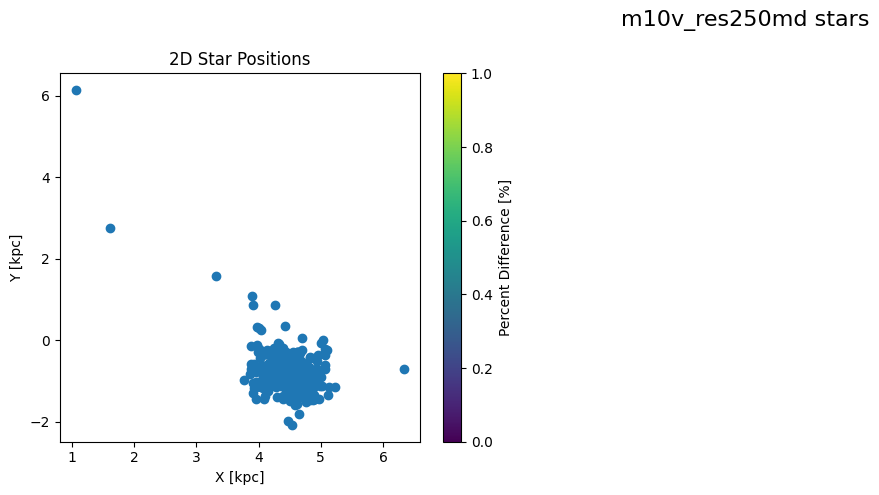

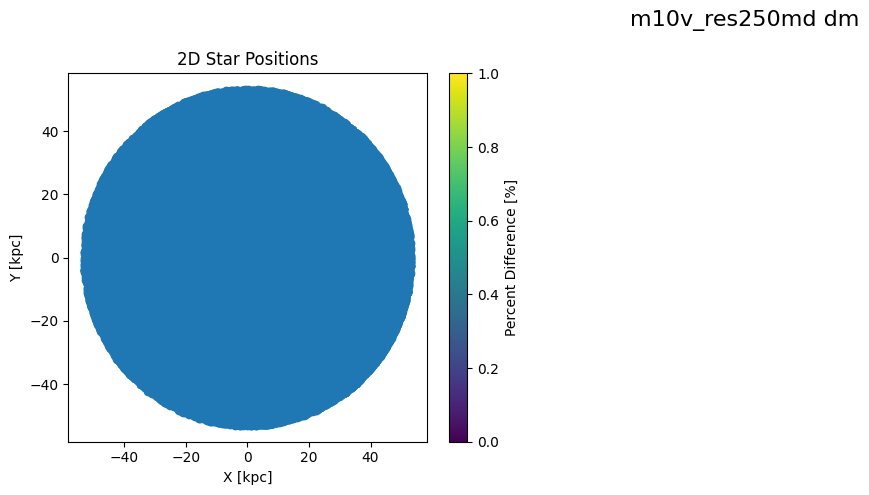

In [10]:
import matplotlib.pyplot as plt, numpy as np, joblib, os, time, bisect
from stellarutil import Simulation
from IPython.display import clear_output


def graph(x,y, title):
    # Create a figure
    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)
    # 2D Scatter Plot
    plt.subplot(1, 3, 1) # rows, cols, index
    plt.title("2D Star Positions")
    plt.scatter(x, y, label='Data Points', vmin=0, vmax=100)
    cb = plt.colorbar()
    cb.set_label('Percent Difference [%]')
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    # Show the plots
    plt.tight_layout()
    plt.show()
    

sim = Simulation(simulation_name="m10v_res250md", species=['star', 'dark'])
clear_output()
halo = sim.get_halo()
halo.restrict_percentage(15)

x = [star.x for star in halo.stars]
y = [star.y for star in halo.stars]
graph(x, y, "m10v_res250md stars")

# Get the x,y,z positions of each dm particle in the simulation, normalize it with halo center
dark_x = sim.particles['dark']['position'][:,0]
dark_y = sim.particles['dark']['position'][:,1]
dark_z = sim.particles['dark']['position'][:,2]
# Get the x,y,z positions of each dm particle in the simulation, normalize it with halo center
halo_dark_x = dark_x - halo.xc
halo_dark_y = dark_y - halo.yc
halo_dark_z = dark_z - halo.zc
# Get the distance of each dm particle from the center of the indicated dark matter halo
halo_dark_distances = np.sqrt(np.square(halo_dark_x) + np.square(halo_dark_y) + np.square(halo_dark_z))

halo_dark_x = halo_dark_x[halo_dark_distances < halo.radius]
halo_dark_y = halo_dark_y[halo_dark_distances < halo.radius]
graph(halo_dark_x, halo_dark_y, "m10v_res250md dm")

